# CredCastle Experiments

## Import Stuff

In [556]:
import numpy as np
import random as random

from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor


## Initial Params

In [557]:
genesis_states = {
    # the castle
    'castle': 1,
    # the difficulty of building the castle
    'difficulty': 1000, 
    # the folks in the village
    'village_population': 1000,
    # the number of dragons in cred land
    'dragons': 3,
}

sim_config_dict = {
    # days
    'T': range(1000), 
    # parallel universes
    'N': 3,
    #'M': {}
}

## Policy Functions

In [558]:
def p_working_villagers(params, step, sH, s):
    working_villagers = np.random.randint(1, s['village_population'])
    return ({'working_villagers': working_villagers})

def p_villager_effort(params, step, sH, s):
    villager_effort = np.random.randint(1, 10)
    return ({'villager_effort': villager_effort})

def p_there_be_dragons(params, step, sH, s):
    there_be_dragons = False
    if random.randint(1, 10) <= s['dragons']:
        there_be_dragons = True
    return ({'there_be_dragons': there_be_dragons})

## State Update Functions

In [559]:
def s_build_castle(params, step, sH, s, _input):
    y = 'castle'
    x = s[y]
    # villagers do work
    add_to_castle = round(_input['working_villagers'] * _input['villager_effort'] / s['difficulty'])
    # dragons may damange castle
    if _input['there_be_dragons']:
        add_to_castle -= s['dragons']
    # result
    x += add_to_castle
    return (y, x)

def s_dragons_eat_villagers(params, step, sH, s, _input):
    y = 'village_population'
    x = s[y]
    # dragons eat villagers
    if _input['there_be_dragons']:
        x -= s['dragons']
    # if all the villagers are eaten the dragons leave
    if x <= 0:
        x = 0
        s['dragons'] = 0
    return (y, x)



## State Update Blocks

In [560]:
partial_state_update_blocks = [
    { 
        # policies represent the behavior of agents that interact with components of the system
        'policies': { 
            'villager_effort': p_villager_effort,
            'working_villagers': p_working_villagers,
            'there_be_dragons': p_there_be_dragons
        },
        # state variables that will be updated
        'variables': {
            'castle': s_build_castle,
            'village_population': s_dragons_eat_villagers
        }
    }
]

## Putting it all together

In [561]:
# imported some addition utilities to help with configuration set-up
exp = Experiment()
c = config_sim(sim_config_dict)
# The configurations above are then packaged into a `Configuration` object
del configs[:]
# dict containing variable names and initial values
exp.append_configs(initial_state=genesis_states, 
                    # dict containing state update functions 
                    partial_state_update_blocks=partial_state_update_blocks, 
                    # preprocessed dictionaries containing simulation parameters
                    sim_configs=c)

## Running the engine

In [562]:
%%capture
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)

# pass the configuration object inside an array
simulation = Executor(exec_context=local_mode_ctx, configs=configs) 
# the `execute()` method returns a tuple; its first elements contains the raw results
raw_system_events, tensor_field, sessions = simulation.execute() 

## Data Viz

In [563]:
%matplotlib inline
import pandas as pd
simulation_result = pd.DataFrame(raw_system_events)
simulation_result.set_index(['subset', 'run', 'timestep', 'substep'])

castle  difficulty  village_population  dragons  \
subset run timestep substep                                                    
0      1   0        0             1        1000                1000        3   
           1        1             0        1000                 997        3   
           2        1            -2        1000                 994        3   
           3        1             0        1000                 994        3   
           4        1             2        1000                 991        3   
...                             ...         ...                 ...      ...   
       3   996      1           396        1000                 109        3   
           997      1           396        1000                 109        3   
           998      1           397        1000                 109        3   
           999      1           397        1000                 109        3   
           1000     1           397        1000                 109        3   

                             simulation  
subset run timestep substep              
0      1   0        0                 0  
           1        1                 0  
           2        1                 0  
           3        1                 0  
           4        1                 0  
...                                 ...  
       3   996      1                 0  
           997      1                 0  
           998      1                 0  
           999      1                 0  
           1000     1                 0  

[3003 rows x 5 columns]

<AxesSubplot:xlabel='timestep'>

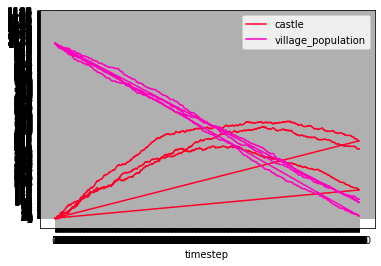

In [564]:
simulation_result.plot('timestep', ['castle', 'village_population'], grid=True, 
        colormap = 'gist_rainbow',
        xticks=list(simulation_result['timestep'].drop_duplicates()), 
        yticks=list(range(1+(simulation_result['castle']+simulation_result['village_population']).max())))